In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# lets have a quick look at the data file structure
base_dir = '/kaggle/input/tomatoleaf/tomato'
for directory in os.listdir(base_dir):
    print(f'The parent directory is {base_dir}/{directory}')

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


The parent directory is /kaggle/input/tomatoleaf/tomato/cnn_train.py
The parent directory is /kaggle/input/tomatoleaf/tomato/val
The parent directory is /kaggle/input/tomatoleaf/tomato/train


In [2]:
import tensorflow as tf
is_cuda_gpu_available = tf.test.is_gpu_available(cuda_only=True)
is_cuda_gpu_available

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


True

In [3]:
# function to find the number of categories in 
def calculate_categories_num(folder_dir):
    return len(os.listdir(folder_dir))

In [4]:
# the number of directories in the train and validation directory equals the number of categories
train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir,'val')

validation_categories = calculate_categories_num(validation_dir)
train_categories = calculate_categories_num(train_dir)

print(f'The number of categories in the validation directory is {validation_categories}')
print(f'The number of categories in the train directory is {train_categories}')

The number of categories in the validation directory is 10
The number of categories in the train directory is 10


In [5]:
# This means our dataset contains 38 different categories that need to be classified
# lets print this categories out
def print_categories(folder_dir):
    categories = []
    for direc in os.listdir(folder_dir):
        categories.append(direc)
        print(direc)
    return categories

In [6]:
print('TRAINING CATEGORIES')
train_cat = print_categories(train_dir)
print('VALIDATION CATEGORIES')
val_cat = print_categories(validation_dir)

TRAINING CATEGORIES
Tomato___Late_blight
Tomato___healthy
Tomato___Early_blight
Tomato___Septoria_leaf_spot
Tomato___Tomato_Yellow_Leaf_Curl_Virus
Tomato___Bacterial_spot
Tomato___Target_Spot
Tomato___Tomato_mosaic_virus
Tomato___Leaf_Mold
Tomato___Spider_mites Two-spotted_spider_mite
VALIDATION CATEGORIES
Tomato___Late_blight
Tomato___healthy
Tomato___Early_blight
Tomato___Septoria_leaf_spot
Tomato___Tomato_Yellow_Leaf_Curl_Virus
Tomato___Bacterial_spot
Tomato___Target_Spot
Tomato___Tomato_mosaic_virus
Tomato___Leaf_Mold
Tomato___Spider_mites Two-spotted_spider_mite


In [7]:
# as you can see from the results above train and validation categories are same 
# the can be validated by running a set union on both train_cat and val_cat and checking if the length of the
# union result is same as either of them

len({*train_cat}.union({*val_cat}))


10

In [8]:
# we would now find the number of images in each category and try to plot how much percentage they make up from the total number 
# of images in the dataset
def categories_percentage(folder_dir):
    cat_percent_dict = {}
    for direc in os.listdir(folder_dir):
            cat_percent_dict[f'{direc}'] = len(os.listdir(os.path.join(f'{folder_dir}',f'{direc}')))
    return cat_percent_dict

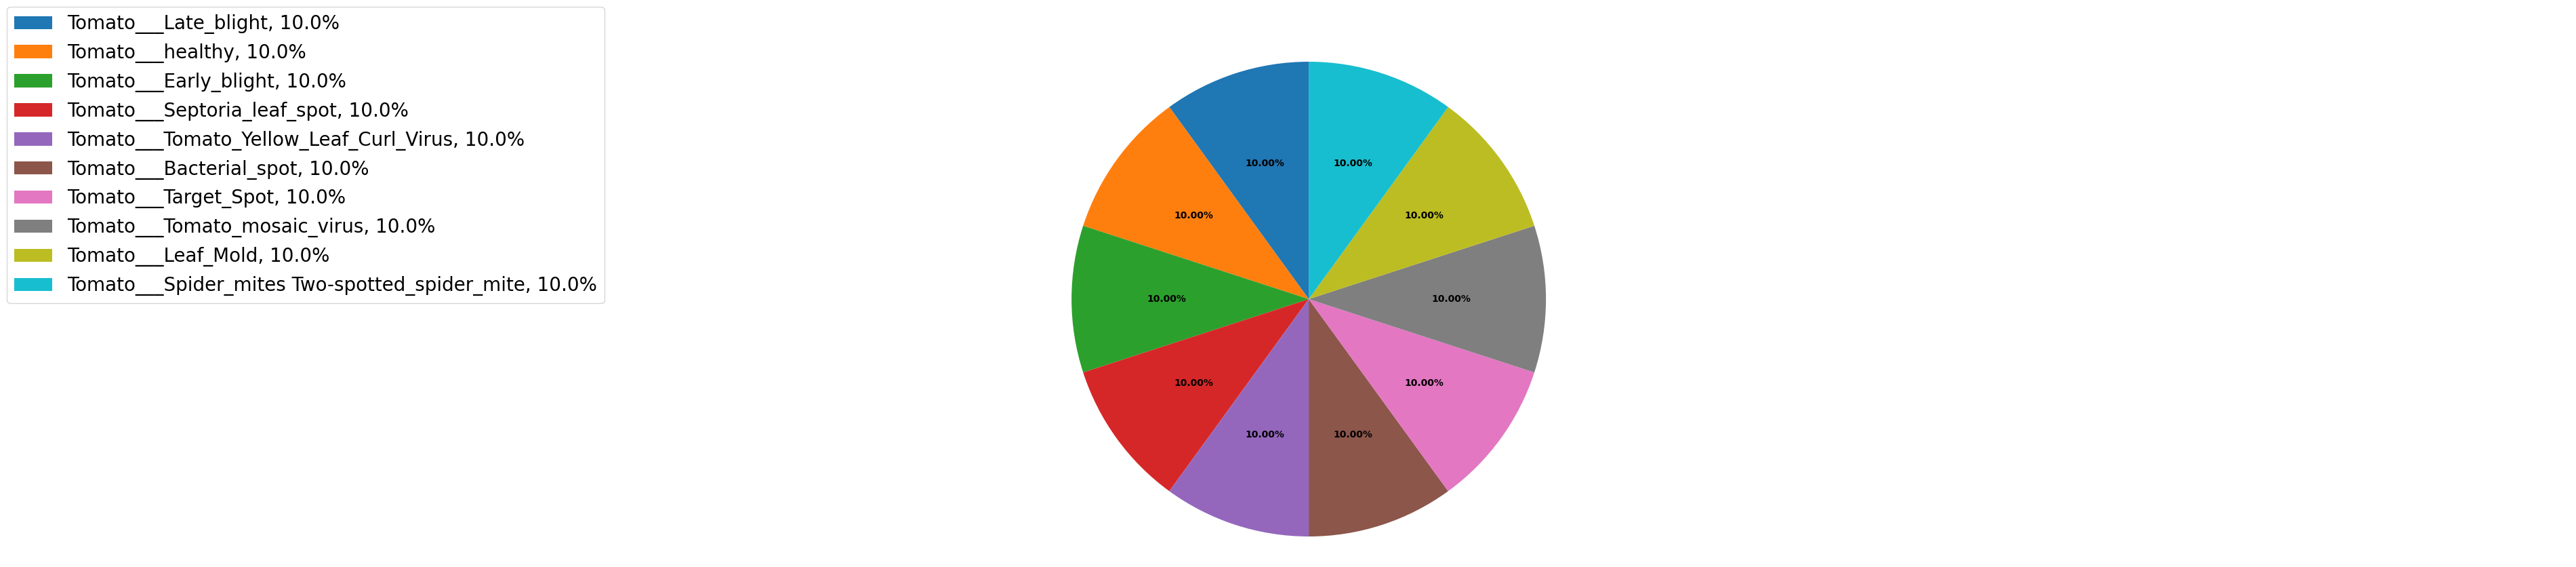

In [9]:
import matplotlib.pyplot as plt
import seaborn

train_cat_num = categories_percentage(train_dir)
def autopct_generator(limit):
    """Remove percent on small slices."""
    def inner_autopct(pct):
        return ('%.2f%%' % pct) if pct > limit else ''
    return inner_autopct

#define Seaborn color palette to use
#palette_color = seaborn.color_palette('bright')
fig1, ax1 = plt.subplots(figsize=(6, 5))
box = box = ax1.get_position()
ax1.set_position([box.x0, box.y0-box.height, box.width * 8, box.height*2])
# plotting data on chart
_, _, autotexts = ax1.pie(
    train_cat_num.values(), autopct=autopct_generator(7), startangle=90, radius=4000)
for autotext in autotexts:
    autotext.set_weight('bold')
ax1.axis('equal')
total = sum(train_cat_num.values())
plt.legend(
    loc='upper left',
    labels=['%s, %1.1f%%' % (
        l, (float(s) / total) * 100) for l, s in zip(train_cat_num.keys(), train_cat_num.values())],
    prop={'size': 20},
    bbox_to_anchor=(0.0, 1),
    bbox_transform=fig1.transFigure
)

#plt.pie(train_cat_num.values(), labels=train_cat_num.keys(), colors=palette_color, autopct='%.0f%%')
  
# displaying chart
#plt.show()

In [10]:
import matplotlib.image as mpimg
w = 250
h = 250
fig = plt.figure(figsize=(15, 15))
columns = 5
rows = 4
num_choices = 20
# plot random images from train and validation dataset
# 'Potato___Late_blight'
def plot_category(folder_dir):
    fig = plt.figure(figsize=(15, 15))
    print(f'PLOTTING IMAGES IN {folder_dir}')
    random_train_image_directories = np.random.choice(os.listdir(os.path.join(train_dir,folder_dir)),num_choices)
    
    for i,img_dir in enumerate(random_train_image_directories):
        img = mpimg.imread(os.path.join(train_dir,folder_dir,img_dir))
        fig.add_subplot(rows, columns, i+1)
        imgplot = plt.imshow(img)
    plt.show()

<Figure size 1500x1500 with 0 Axes>

In [11]:
CLASS_NAMES = train_cat.copy()
#initialising necessary properties
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(10000/BATCH_SIZE)

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
t =  f'{base_dir}/train'
v = f'{base_dir}/val'
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
# test data generator
test_datagen = ImageDataGenerator(rescale=1./255)
# training data generator
train_generator = train_datagen.flow_from_directory(
        t,
        batch_size=BATCH_SIZE,
        shuffle=True,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        classes = list(CLASS_NAMES),
       # subset='training'
)
# validation data generator
validation_generator = test_datagen.flow_from_directory(
        v,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        classes = list(CLASS_NAMES),
        batch_size=BATCH_SIZE,
        #subset='training'
)

Found 10000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


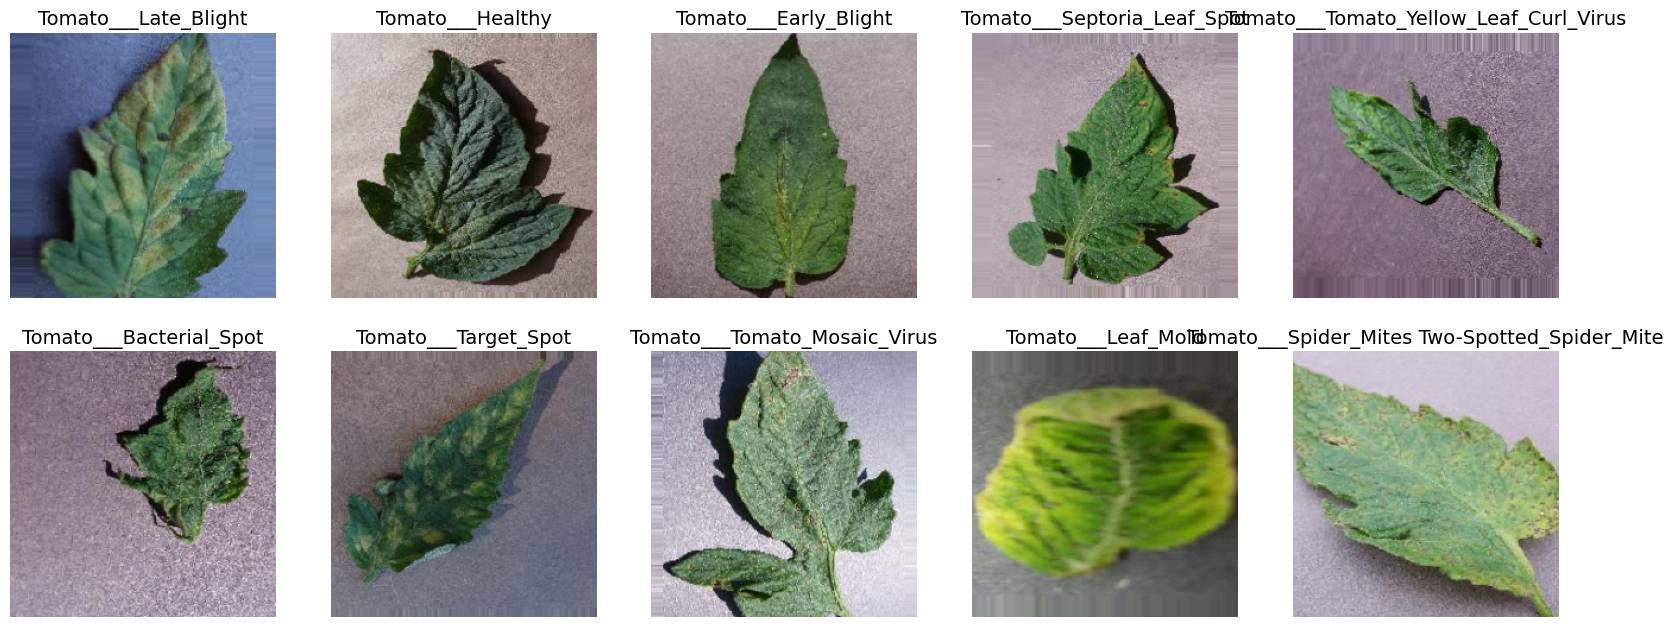

In [13]:
#vizualise the loaded images
def show_batch(image_batch, label_batch):
      fig = plt.figure(figsize=(20,20))
      fig.patch.set_facecolor('white')
      for n in range(10):
          ax = plt.subplot(5,5,n+1)
          plt.imshow(image_batch[n])
          plt.title(CLASS_NAMES[n].title(), fontsize=14)
          plt.axis('off')
image_batch, label_batch = next(train_generator)
show_batch(image_batch, label_batch)

In [14]:
import tensorflow as tf
from tensorflow.keras import layers
# Define the model architecture
model = tf.keras.Sequential([
    # First convolutional layer
    layers.Conv2D(64, (7, 7), activation='relu', padding='same', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    # Second convolutional layer
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    # Third convolutional layer
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    # Flatten the output of the convolutional layers
    layers.Flatten(),
    # Dense layer with 512 units
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    # Output layer with 10 units (one for each class)
    layers.Dense(10, activation='softmax')
])

In [15]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Reduce learning rate when there is a change lesser than <min_delta> in <val_accuracy> for more than <patience> epochs
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 mode = 'max',
                                                 min_delta = 0.01,
                                                 patience = 3,
                                                 factor = 0.25,
                                                 verbose = 1,
                                                 cooldown = 0,
                                                 min_lr = 0.00000001)

# Stop the training process when there is a change lesser than <min_delta> in <val_accuracy> for more than <patience> epochs
early_stopper = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 mode = 'max',
                                                 min_delta = 0.005,
                                                 patience = 10,
                                                 verbose = 1,
                                                 restore_best_weights = True)

#  Save best model every epoch
# model_checkpoint = tf.keras.callbacks.ModelCheckpoint('.')
#fit the model

# Train the model
# history = model.fit(train_generator epochs=50, batch_size=128, validation_data=validation_generator,ccallbacks=[early_stopper, reduce_lr])
history = model.fit(train_generator, 
                    epochs=14,
                    validation_data = validation_generator,
                    callbacks=[early_stopper, reduce_lr])

Epoch 1/14
313/313 [==============================] - 175s 526ms/step - loss: 1.0020 - accuracy: 0.6879 - val_loss: 5.9313 - val_accuracy: 0.2050 - lr: 0.0010
Epoch 2/14
313/313 [==============================] - 119s 379ms/step - loss: 0.5138 - accuracy: 0.8257 - val_loss: 29.6908 - val_accuracy: 0.1390 - lr: 0.0010
Epoch 3/14
313/313 [==============================] - 122s 389ms/step - loss: 0.4541 - accuracy: 0.8397 - val_loss: 0.7593 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 4/14
313/313 [==============================] - 118s 376ms/step - loss: 0.3041 - accuracy: 0.8960 - val_loss: 1.3315 - val_accuracy: 0.6180 - lr: 0.0010
Epoch 5/14
313/313 [==============================] - 119s 379ms/step - loss: 0.3174 - accuracy: 0.8945 - val_loss: 6.6577 - val_accuracy: 0.2640 - lr: 0.0010
Epoch 6/14
313/313 [==============================] - 121s 387ms/step - loss: 0.2321 - accuracy: 0.9226 - val_loss: 0.4793 - val_accuracy: 0.8380 - lr: 0.0010
Epoch 7/14
313/313 [=========================

In [16]:
model.save("model_(7X7)_convolution_classifier.h5")

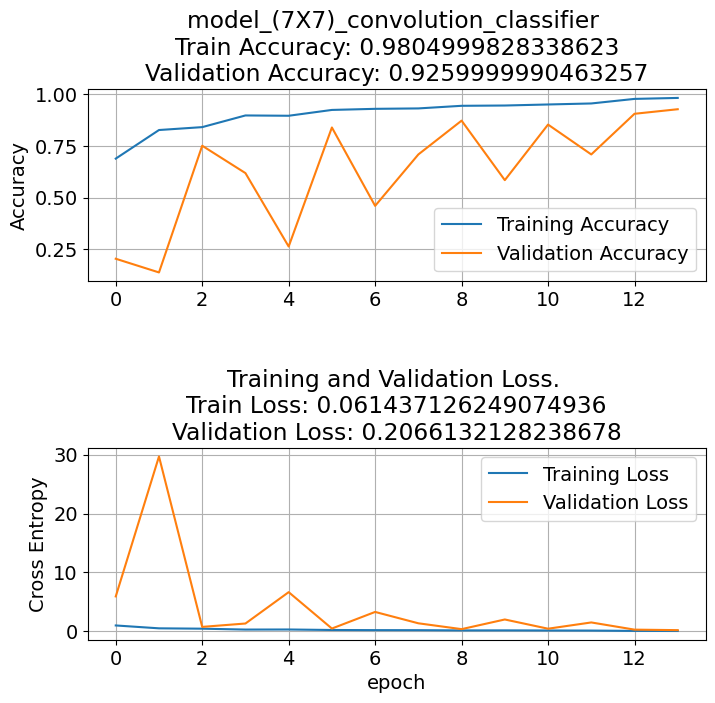

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

#plot results
#accuracy
plt.figure(figsize=(8, 8))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'model_(7X7)_convolution_classifier \nTrain Accuracy: {str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')

#loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss: {str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

In [18]:
extractor = tf.keras.Model(inputs=model.input,outputs=[model.layers[-2].output])
extractor.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      9472      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0     

In [19]:
def extract_features(datagen,iterations):
    features = []
    labels = []
    i = 1
    for _,(image_batch,label_batch) in enumerate(datagen):
        if i > iterations:
            break
        print(f'extracting features for batch.....{i}')
        batch_features = extractor.predict(image_batch)
        labels_list =  np.argmax(label_batch,axis=1)
        for img, label in zip(batch_features,labels_list):
            features.append(img)
            labels.append(label)
        i+=1
    return features, labels

In [20]:
train_x, train_y = extract_features(train_generator,150)

extracting features for batch.....1
1/1 [==============================] - 0s 222ms/step
extracting features for batch.....2
1/1 [==============================] - 0s 30ms/step
extracting features for batch.....3
1/1 [==============================] - 0s 27ms/step
extracting features for batch.....4
1/1 [==============================] - 0s 27ms/step
extracting features for batch.....5
1/1 [==============================] - 0s 35ms/step
extracting features for batch.....6
1/1 [==============================] - 0s 26ms/step
extracting features for batch.....7
1/1 [==============================] - 0s 36ms/step
extracting features for batch.....8
1/1 [==============================] - 0s 26ms/step
extracting features for batch.....9
1/1 [==============================] - 0s 26ms/step
extracting features for batch.....10
1/1 [==============================] - 0s 27ms/step
extracting features for batch.....11
1/1 [==============================] - 0s 38ms/step
extracting features for batch

In [21]:
validation_test_features,validation_test_labels = extract_features(validation_generator,20)

extracting features for batch.....1
1/1 [==============================] - 0s 27ms/step
extracting features for batch.....2
1/1 [==============================] - 0s 26ms/step
extracting features for batch.....3
1/1 [==============================] - 0s 26ms/step
extracting features for batch.....4
1/1 [==============================] - 0s 27ms/step
extracting features for batch.....5
1/1 [==============================] - 0s 37ms/step
extracting features for batch.....6
1/1 [==============================] - 0s 29ms/step
extracting features for batch.....7
1/1 [==============================] - 0s 28ms/step
extracting features for batch.....8
1/1 [==============================] - 0s 28ms/step
extracting features for batch.....9
1/1 [==============================] - 0s 28ms/step
extracting features for batch.....10
1/1 [==============================] - 0s 32ms/step
extracting features for batch.....11
1/1 [==============================] - 0s 37ms/step
extracting features for batch.

In [22]:
print(f'Training data is now {len(train_x)} an increase by {len(train_x)-10000} through augmentation')
print(f'Validation data is now {len(validation_test_features)} an increase by {len(validation_test_features)-1000} through augmentation')

Training data is now 4800 an increase by -5200 through augmentation
Validation data is now 640 an increase by -360 through augmentation


In [23]:
from sklearn.model_selection import train_test_split
# we would use the sklearn train_test_split to 
# split the validation dataset into 95% test and 5% validation 
val_x,test_x,val_y, test_y= train_test_split(validation_test_features,validation_test_labels,test_size=0.95, random_state=42)

In [24]:
# add the validation and training data into X and Y

X_data = []
Y_data = []

# training data
for x,y in zip(train_x,train_y):
    X_data.append(x)
    Y_data.append(y)
    
# validation data
for x,y in zip(val_x,val_y):
    X_data.append(x)
    Y_data.append(y)

In [25]:
from sklearn import svm
# importing some evaluationn metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

In [26]:
poly = svm.SVC(kernel='poly', degree=3, C=1).fit(train_x, train_y)

Accuracy (POLY Kernel):  96.88
F1 (POLY Kernel):  97.01


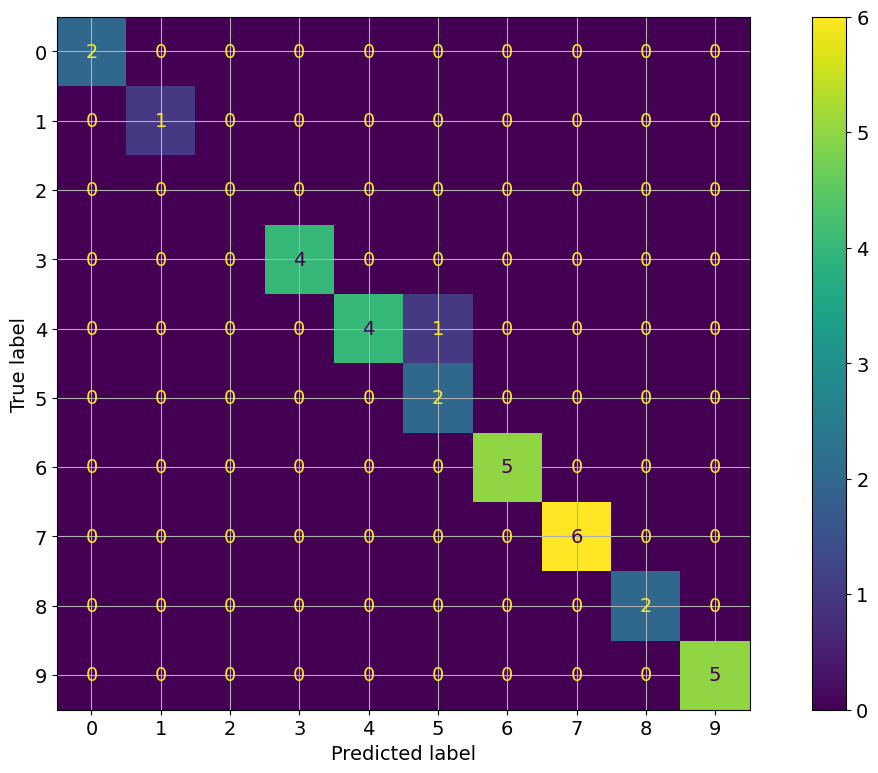

In [27]:
poly_pred_val = poly.predict(val_x)
poly_accuracy_val = accuracy_score(val_y, poly_pred_val)
poly_f1_val = f1_score(val_y, poly_pred_val, average='weighted')
cm = confusion_matrix(val_y, poly_pred_val,labels=poly.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=poly.classes_)
disp.plot()
print('Accuracy (POLY Kernel): ', "%.2f" % (poly_accuracy_val*100))
print('F1 (POLY Kernel): ', "%.2f" % (poly_f1_val*100))

Accuracy (Poly2 Kernel with degree 2):  92.27
F1 (Poly2 Kernel with degree 2):  92.37


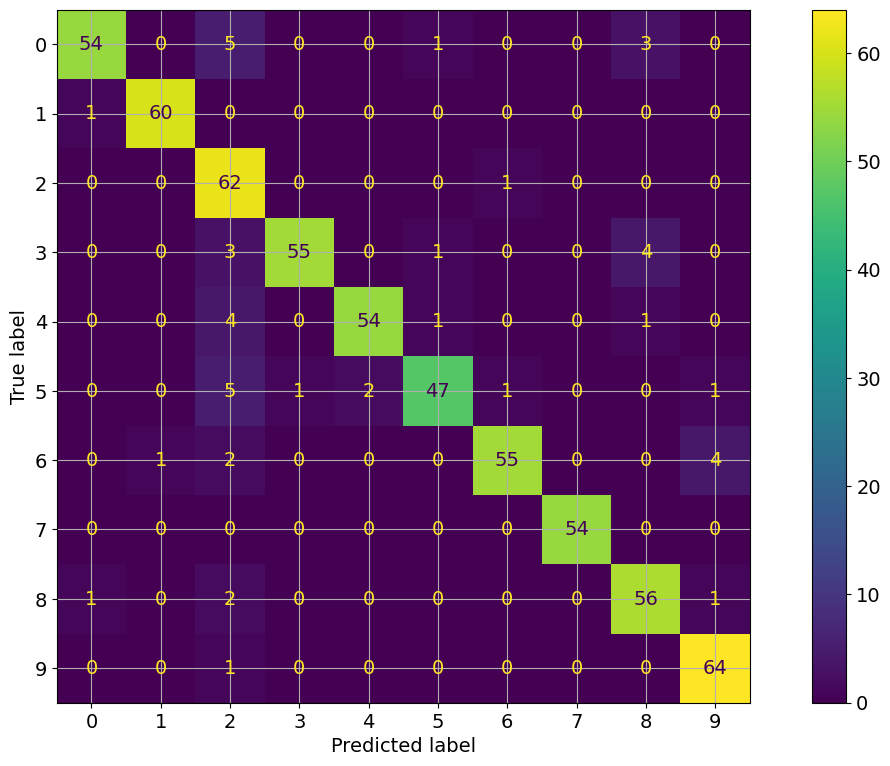

In [28]:
# changing the degree to 2 has boosted the performance a bit
poly_pred_test = poly.predict(test_x)
poly_accuracy_test = accuracy_score(test_y, poly_pred_test)
poly_f1_test = f1_score(test_y, poly_pred_test, average='weighted')
cm = confusion_matrix(test_y, poly_pred_test,labels=poly.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=poly.classes_)
disp.plot()
print('Accuracy (Poly2 Kernel with degree 2): ', "%.2f" % (poly_accuracy_test*100))
print('F1 (Poly2 Kernel with degree 2): ', "%.2f" % (poly_f1_test*100))

In [29]:
# generating classification report
from sklearn.metrics import classification_report
report = classification_report(test_y,poly_pred_test)
print(report)

              precision    recall  f1-score   support

           0       0.96      0.86      0.91        63
           1       0.98      0.98      0.98        61
           2       0.74      0.98      0.84        63
           3       0.98      0.87      0.92        63
           4       0.96      0.90      0.93        60
           5       0.94      0.82      0.88        57
           6       0.96      0.89      0.92        62
           7       1.00      1.00      1.00        54
           8       0.88      0.93      0.90        60
           9       0.91      0.98      0.95        65

    accuracy                           0.92       608
   macro avg       0.93      0.92      0.92       608
weighted avg       0.93      0.92      0.92       608



In [30]:
# create the svm classifier to show the learning curve of the model
from sklearn.model_selection import learning_curve
from sklearn.model_selection import  ShuffleSplit
from sklearn.metrics import PrecisionRecallDisplay
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
# add noisy features
# Add noisy features
random_state = np.random.RandomState(0)

# Use label_binarize to be multi-label like settings
Y = label_binarize(Y_data, classes=[0, 1, 2,3,4,5,6,7,8,9])
n_classes = Y.shape[1]

# Split into training and test
X_train, X_test, Y_train, Y_test = train_test_split(
    X_data, Y, test_size=0.5, random_state=random_state
)

classifier = OneVsRestClassifier(
    make_pipeline(StandardScaler(), poly)
)
classifier.fit(X_train, Y_train)
y_score = classifier.decision_function(X_test)

In [31]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(
    Y_test.ravel(), y_score.ravel()
)
average_precision["micro"] = average_precision_score(Y_test, y_score, average="micro")

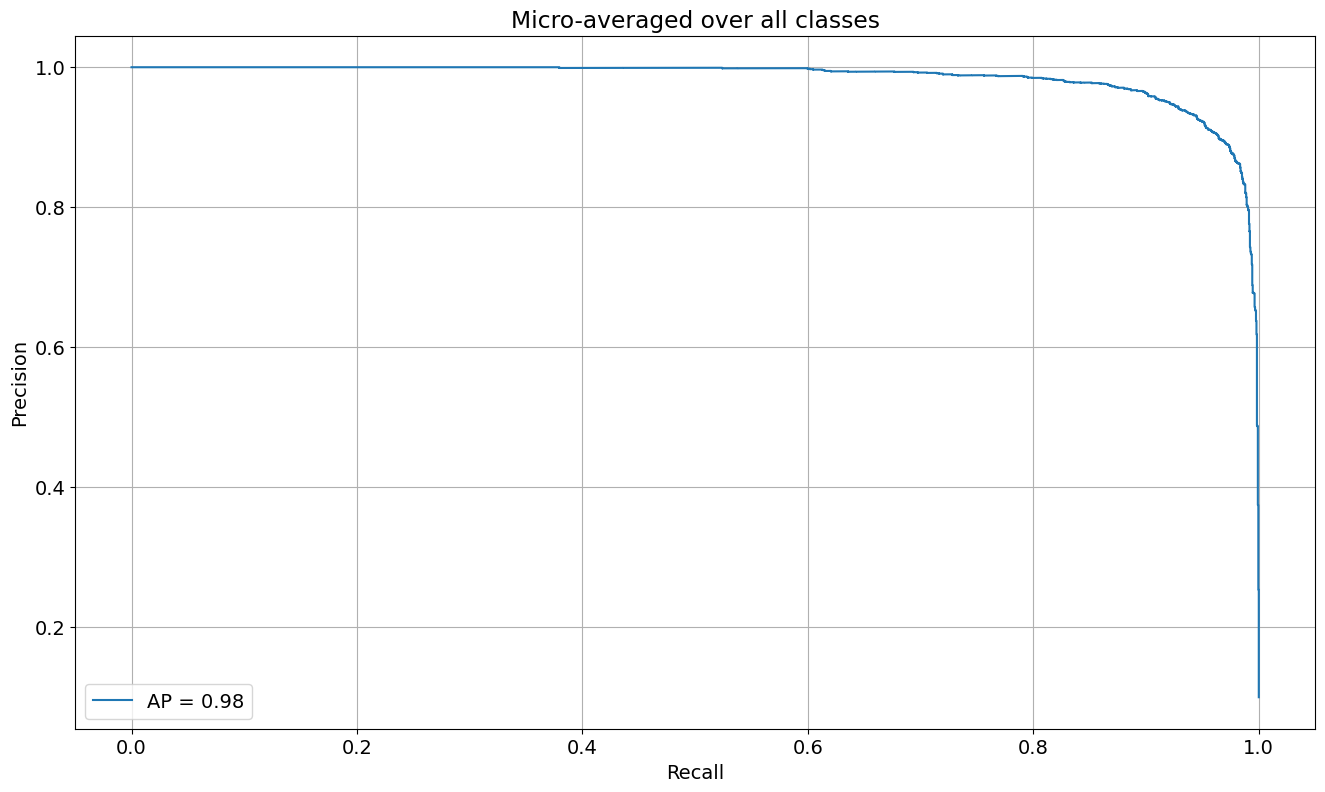

In [32]:
display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot()
_ = display.ax_.set_title("Micro-averaged over all classes")

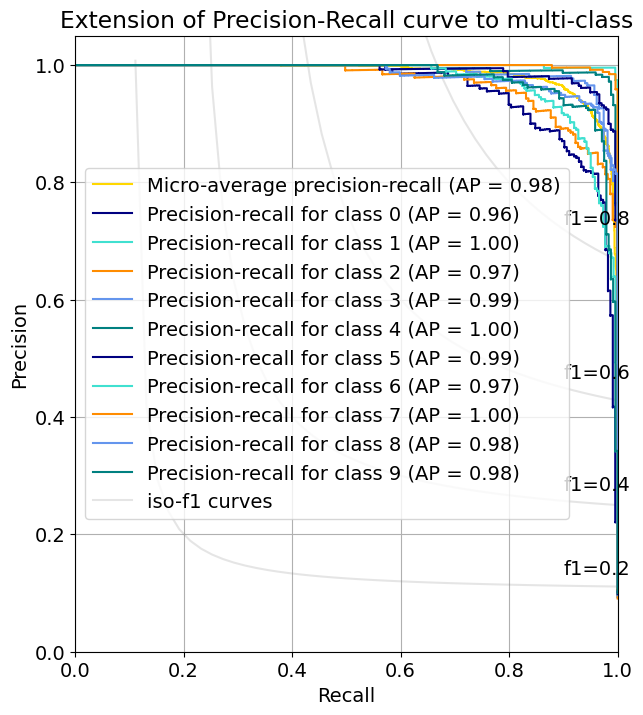

In [33]:
import matplotlib.pyplot as plt
from itertools import cycle

# setup plot details
colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal"])

_, ax = plt.subplots(figsize=(7, 8))

f_scores = np.linspace(0.2, 0.8, num=4)
lines, labels = [], []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
    plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot(ax=ax, name="Micro-average precision-recall", color="gold")

for i, color in zip(range(n_classes), colors):
    display = PrecisionRecallDisplay(
        recall=recall[i],
        precision=precision[i],
        average_precision=average_precision[i],
    )
    display.plot(ax=ax, name=f"Precision-recall for class {i}", color=color)

# add the legend for the iso-f1 curves
handles, labels = display.ax_.get_legend_handles_labels()
handles.extend([l])
labels.extend(["iso-f1 curves"])
# set the legend and the axes
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.legend(handles=handles, labels=labels, loc="best")
ax.set_title("Extension of Precision-Recall curve to multi-class")

plt.show()